In [1]:
#########################
#
# Implementing AlexNet on Imagenet ILSVRC 2012 data (1.2 million training images)
#
#########################

In [2]:
# version 3
# implementing the tensorboad summaries to track the training progress.

In [15]:
import tensorflow as tf
import scipy.io as sio
#import mat4py
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [29]:
# Constants
imageNetTrainingDataFolder = 'D:/Anurag/IMAGENET_DATA/train/train'
imageNetValidationDataFolder = 'D:/Anurag/IMAGENET_DATA/validation'

imageNetMetaDataFile = "D:/Anurag/IMAGENET_DATA/devKit/data/meta.mat"

imageNetValidationImageClassesFile = 'D:/Anurag/IMAGENET_DATA/devKit/data/ILSVRC2012_validation_ground_truth.txt'

trainedModelPath = 'D:/Anurag/watermarking/imageNetCode/savedModel/LR_e-2_WD_e-3'

_WEIGHT_DECAY = 0.001
_LEARNING_RATE = 0.01
_NUM_EPOCHS = 200
_BATCH_SIZE = 128

_SAVE_MODEL_EVERY_NUM_EPOCHS = 10

_HALVE_LEARNING_RATE_EVERY_NUM_EPOCHS = 20

_TENSORBOARD_TRAIN_LOGDIR='D:/Anurag/watermarking/imageNetCode/tensorboard_logdir/LR_e-2_WD_e-3'

In [17]:
# Load the classes data
# sysSetToClass is a dictionary containing: {'n02100735': {'ID': 1, 'words': 'English setter', 'gloss': 'an English breed... '}}
synSetToClass = {}

#classToSynSet is a dictionary containing: {1: {'wnid': n02100735, 'words': 'English setter', 'gloss': 'an English breed... '}}
classToSynSet = {}

# we will also create a HashMap in TF for use in training. The above data-structures are used only for sample visualisation
synSetArray_tf = []
classIDArray_tf = []

In [18]:
metaData = sio.loadmat(imageNetMetaDataFile) 
#metaData = mat4py.loadmat(imageNetMetaDataFile)
synSetsData = metaData['synsets']

In [19]:
for i in range(0, len(synSetsData)):
    synSetToClass[synSetsData['WNID'][i][0][0]] = {'ID': synSetsData['ILSVRC2012_ID'][i][0][0][0], 'words': synSetsData['words'][i][0][0], 'gloss': synSetsData['gloss'][i][0][0]}
    classToSynSet[synSetsData['ILSVRC2012_ID'][i][0][0][0]] = {'wnid': synSetsData['WNID'][i][0][0], 'words': synSetsData['words'][i][0][0], 'gloss': synSetsData['gloss'][i][0][0]}
    
    synSetArray_tf.append(synSetsData['WNID'][i][0][0])
    classIDArray_tf.append(synSetsData['ILSVRC2012_ID'][i][0][0][0])

In [20]:
def getSynSetFromFileName(filename):
    #training image file name is of form: n01440764_10108.JPEG
    locationOfUnderScore = filename.find('_', 0, len(filename))
    return filename[0:locationOfUnderScore]

In [21]:
def getTrainingLabelsFromFileName(filename):
    synset = getSynSetFromFileName(filename)
    label = synSetToClass[synset]['words']
    
    return label

Image  0  dimensions: (600, 447, 3)
Image  1  dimensions: (375, 500, 3)
Image  2  dimensions: (339, 500)
Image  3  dimensions: (375, 500, 3)


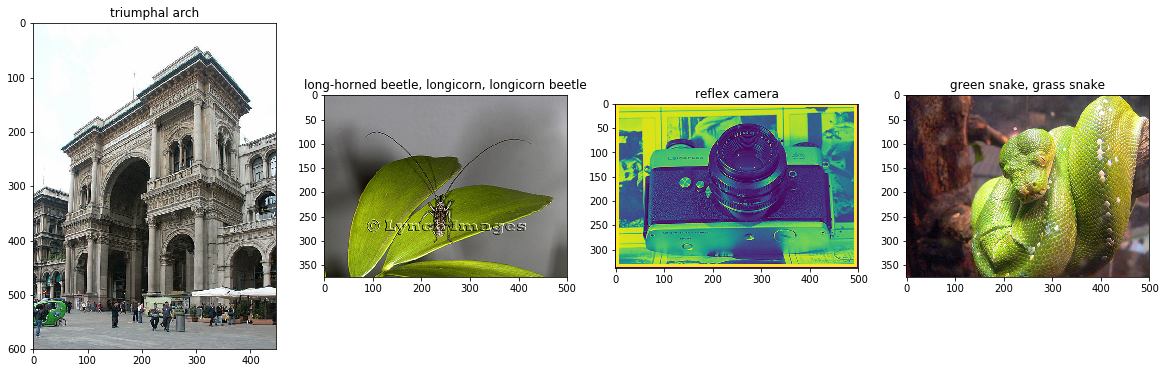

In [25]:
# Visualising a few training images
filesInFolder = os.listdir(imageNetTrainingDataFolder)
trainingImageFiles = filesInFolder
#pick 4 random images
trainingImagesToVisualise = []
labelsOfTrainingImagesToVisualise = []
images=[]

fig, ax = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    trainingImagesToVisualise.append(filesInFolder[random.randrange(0, len(filesInFolder))])
    labelsOfTrainingImagesToVisualise.append(getTrainingLabelsFromFileName(trainingImagesToVisualise[i]))
    images.append(mpimg.imread(imageNetTrainingDataFolder + '/' + trainingImagesToVisualise[i]))
    
    ax[i].imshow(images[i])
    ax[i].set_title(labelsOfTrainingImagesToVisualise[i])
    
    print("Image ", i, ' dimensions:', images[i].shape)

In [26]:
def getFileNumberFromFileName(filename):
    locationOfFirstUnderscore = filename.find('_', 0, len(filename))
    locationOfSecondUnderscore = filename.find('_', locationOfFirstUnderscore+1, len(filename))
    locationOfPeriod = filename.find('.', locationOfSecondUnderscore, len(filename))
    
    return int(filename[locationOfSecondUnderscore+1:locationOfPeriod])

In [27]:
def getValidationLabelsFromFileName(filename):
    # validation images are of the form: ILSVRC2012_val_00000019.JPEG.
    # the class is in another file (ILSVRC2012_validation_ground_truth.txt) 
    fileNumber = getFileNumberFromFileName(filename)
    with open(imageNetValidationImageClassesFile, 'r') as f:
        classIDs = f.readlines()
        classOfValidationImage = classIDs[fileNumber-1]
                
        label = classToSynSet[int(classOfValidationImage)]['words']
    
    return label

Image 0  dimensions: (375, 500, 3)
Image 1  dimensions: (375, 500, 3)
Image 2  dimensions: (324, 433, 3)
Image 3  dimensions: (375, 500, 3)


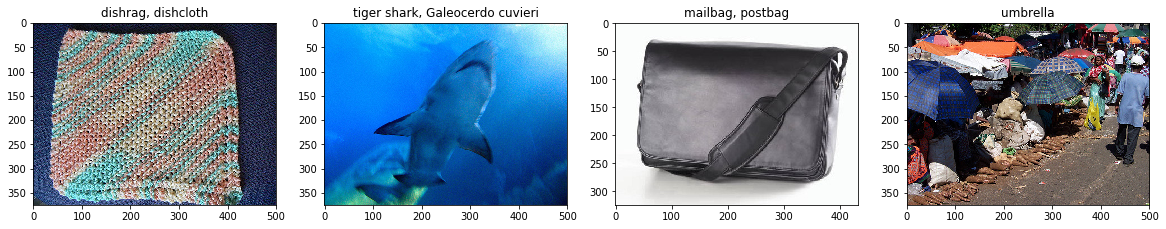

In [30]:
# visualising a few validation images
filesInFolder = os.listdir(imageNetValidationDataFolder)
validationImageFiles = filesInFolder

validationImagesToVisualise = []
labelsOfValidationImagesToVisualise = []
images=[]

fig, ax = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    validationImagesToVisualise.append(filesInFolder[random.randrange(0, len(filesInFolder))])
    labelsOfValidationImagesToVisualise.append(getValidationLabelsFromFileName(validationImagesToVisualise[i]))
    images.append(mpimg.imread(imageNetValidationDataFolder + '/' + validationImagesToVisualise[i]))

    ax[i].imshow(images[i])
    ax[i].set_title(labelsOfValidationImagesToVisualise[i])
    
    print('Image', i, ' dimensions:', images[i].shape)

In [31]:
# AlexNet
tf.reset_default_graph()

In [32]:
inputImagePlaceholder = tf.placeholder(dtype=tf.float32, shape=(None, 227, 227, 3), name='inputImagePH')
inputClassPlaceholder = tf.placeholder(dtype=tf.int8, shape=(None, 1000), name='inputClassPH')
isTraining = tf.placeholder(dtype=tf.bool, name='isTrainingPH')

conv1 = tf.layers.conv2d(inputs=inputImagePlaceholder, filters=96, kernel_size=(11, 11), strides=4, padding='valid', activation=tf.nn.relu, name='conv1') # (?, 55, 55, 96)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(3, 3), strides=2, name='pool1', padding='valid') # (?, 27, 27, 96)
norm1 = tf.layers.batch_normalization(inputs=pool1, training=isTraining, momentum=0.1, name='batchNorm1') #(?, 27, 27, 96)

conv2 = tf.layers.conv2d(inputs=norm1, filters=256, kernel_size=(5, 5), padding='same', strides=1, activation=tf.nn.relu, name='conv2') # (? 27, 27, 256)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(3, 3), strides=2, name='pool2', padding='valid') #(?, 13, 13, 256)
norm2 = tf.layers.batch_normalization(inputs=pool2, training=isTraining, momentum=0.1, name='batchNorm2') #(?, 13, 13, 256)

conv3 = tf.layers.conv2d(inputs=norm2, filters=384, kernel_size=(3, 3), padding='same', strides=1, activation=tf.nn.relu, name='conv3') #(?, 13, 13, 384)
conv4 = tf.layers.conv2d(inputs=conv3, filters=384, kernel_size=(3, 3), padding='same', strides=1, activation=tf.nn.relu, name='conv4') #(?, 13, 13, 384)
conv5 = tf.layers.conv2d(inputs=conv4, filters=256, kernel_size=(3, 3), padding='same', strides=1, activation=tf.nn.relu, name='conv5') #(?, 13, 13, 384)
pool3 = tf.layers.max_pooling2d(inputs=conv5, pool_size=(3, 3), padding='valid', strides=2, name='pool3') #(?, 6, 6, 256)

drop1 = tf.layers.dropout(inputs=pool3, rate=0.5, training=isTraining)
flatten = tf.reshape(tensor=drop1, shape=(-1, 6 * 6 * 256), name='flatten') #(?, 9216)
fc6 = tf.layers.dense(inputs=flatten, units=4096, activation=None, name='fc6', use_bias=False) #(?, 4096)
drop2 = tf.layers.dropout(inputs=fc6, rate=0.5, training=isTraining)
fc7 = tf.layers.dense(inputs=drop2, units=4096, activation=None, name='fc7', use_bias=False) #(?, 4096)

logits = tf.layers.dense(inputs=fc7, units=1000, activation=None, name='outputLogits') #(?, 1000)



In [33]:
outputSoftmax = tf.nn.softmax(logits=logits, name='output_softmax')
predClass = tf.argmax(logits, axis=1)
predClass = tf.reshape(predClass, shape=[-1])
actualClass = tf.argmax(inputClassPlaceholder, axis=1)
actualClass = tf.reshape(actualClass, shape=[-1])
accuracyTrain, accuracyTrainOp = tf.metrics.accuracy(labels=actualClass, predictions=predClass, name='accuracy_training')
accuracyVal, accuracyValOp = tf.metrics.accuracy(labels=actualClass, predictions=predClass, name='accuracy_validation')

In [34]:
crossEntropyLoss = tf.losses.softmax_cross_entropy(onehot_labels=inputClassPlaceholder, logits=logits)
tf.summary.scalar(tensor=crossEntropyLoss, name='crossEntropyLoss')

weightDecayLoss = _WEIGHT_DECAY * tf.add_n( [tf.nn.l2_loss(v) for v in tf.trainable_variables()])
tf.summary.scalar(tensor=weightDecayLoss, name='weightDecayLoss')

loss = crossEntropyLoss + weightDecayLoss
tf.summary.scalar(tensor=loss, name='Trainingloss')

<tf.Tensor 'Trainingloss:0' shape=() dtype=string>

In [35]:
#histograms of the weights
weights = tf.trainable_variables()
#tf.summary.histogram(values=weights, name='histogramOfWeights')

In [36]:
#histogram of the activations of the first layer
tf.summary.histogram(values=conv1, name='histogramOfActivationOfConv1')

<tf.Tensor 'histogramOfActivationOfConv1:0' shape=() dtype=string>

In [37]:
#summary for learning rate
tf.summary.scalar(tensor=_LEARNING_RATE, name='learningRate')

<tf.Tensor 'learningRate:0' shape=() dtype=string>

In [38]:
tf.summary.scalar(tensor=accuracyTrain, name='trainingAccuracy')
tf.summary.scalar(tensor=accuracyVal, name='validationAccuracy')

<tf.Tensor 'validationAccuracy:0' shape=() dtype=string>

In [39]:
tf.summary.histogram(values=outputSoftmax, name='outputSoftmaxScores')

<tf.Tensor 'outputSoftmaxScores:0' shape=() dtype=string>

In [50]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) #to put the dependency for the batch norm
with tf.control_dependencies(update_ops):
    #train_step = tf.train.AdamOptimizer(learning_rate=_LEARNING_RATE).minimize(loss)
    train_step = tf.train.MomentumOptimizer(learning_rate=_LEARNING_RATE, momentum=0.9).minimize(loss)

In [41]:
smallTrainingImageFiles = trainingImageFiles[0: 200]

In [51]:
# Building the Hash Map of synset to class ID. WIll be used in training.
keys_tf = tf.convert_to_tensor(synSetArray_tf, dtype=tf.string)
values_tf = tf.convert_to_tensor(classIDArray_tf, dtype=tf.int32)
synsetToClassID_tf = tf.contrib.lookup.HashTable(tf.contrib.lookup.KeyValueTensorInitializer(keys_tf, values_tf, key_dtype=tf.string, value_dtype=tf.int32), default_value=-1)

In [52]:
# Building the Hash Map of validation image to class ID. Will be used in validation
keys_tf = tf.convert_to_tensor(validationImageFiles, dtype=tf.string)
with open(imageNetValidationImageClassesFile, 'r') as f:
    values = f.readlines()

values = [int(v) for v in values]
values_tf = tf.convert_to_tensor(values, dtype=tf.int32)

validationImageToClassID_tf = tf.contrib.lookup.HashTable(tf.contrib.lookup.KeyValueTensorInitializer(keys_tf, values_tf, key_dtype=tf.string, value_dtype=tf.int32), default_value=-1)

In [53]:
def imageParser(imageFileName):
    
    img = tf.image.decode_jpeg(tf.read_file(imageNetTrainingDataFolder + '/' + imageFileName))
    img = tf.image.resize_images(img, [227, 227])
    img = tf.image.per_image_standardization(img)

    shapeOfImage = tf.shape(img)[2]
    #print('shapeOfImage:', shapeOfImage)
    #print('tf.shape():', tf.shape(img))
    img = tf.cond(shapeOfImage < 3, true_fn=lambda: tf.image.grayscale_to_rgb(img), false_fn=lambda: img)
    img = tf.cond(shapeOfImage > 3, true_fn=lambda: img[:, :, 0:3], false_fn=lambda: img)
    #    img= tf.image.grayscale_to_rgb(img)
    #img = tf.reshape(img, shape=(227, 227, 3))
    
    #get the labels
    padImg = tf.expand_dims(imageFileName, 0)
    synset = tf.string_split(padImg, delimiter='_')
    
    classID = synsetToClassID_tf.lookup(synset.values[0])
    classID_oneHot = tf.one_hot(classID, 1000)
    return (img, classID_oneHot)

In [54]:
def validationImageParser(imageFileName):
    img = tf.image.decode_jpeg(tf.read_file(imageNetValidationDataFolder + '/' + imageFileName))
    img = tf.image.resize_images(img, [227, 227])
    img = tf.image.per_image_standardization(img)
    
    shapeOfImage = tf.shape(img)[2]
    img = tf.cond(shapeOfImage < 3, true_fn=lambda: tf.image.grayscale_to_rgb(img), false_fn=lambda: img)
    img = tf.cond(shapeOfImage > 3, true_fn=lambda: img[:, :, 0:3], false_fn=lambda: img)
    
    classID = validationImageToClassID_tf.lookup(imageFileName)
    classID_oneHot = tf.one_hot(classID, 1000)
    return (img, classID_oneHot)

In [55]:
inputDataset = tf.data.Dataset.from_tensor_slices(trainingImageFiles)#smallTrainingImageFiles)
inputDataset = inputDataset.shuffle(buffer_size=10000)
inputDataset = inputDataset.map(imageParser)
inputDataset = inputDataset.batch(_BATCH_SIZE)
iterator = inputDataset.make_initializable_iterator()
next_element = iterator.get_next()

In [56]:
validationDataset = tf.data.Dataset.from_tensor_slices(validationImageFiles)
validationDataset = validationDataset.map(validationImageParser)
validationDataset = validationDataset.batch(_BATCH_SIZE)
validationIterator = validationDataset.make_initializable_iterator()
next_validation_element = validationIterator.get_next()

In [57]:
with tf.Session() as sess:
    #wnidToClassID_tf.init.run()
    #wnidToClassID_tf = tf.contrib.lookup.HashTable(tf.contrib.lookup.KeyValueTensorInitializer(keys_tf, values_tf), default_value=0)
    #wnidToClassID_tf.lookup()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    sess.run(tf.tables_initializer())
    
    tensorBoard_training_writer = tf.summary.FileWriter(_TENSORBOARD_TRAIN_LOGDIR, 
                                                        sess.graph)
    all_summary_ops = tf.summary.merge_all()
    
    for epc in range(_NUM_EPOCHS):
        sess.run([iterator.initializer, validationIterator.initializer])
        print('------- Starting training for epoch number:', epc)
        #initialise the training metrics variables so that the numbers are accurate for per epoch.
        accuracyTrain_variables = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="accuracy_training")
        sess.run(tf.variables_initializer(var_list=accuracyTrain_variables))
        
        numSteps=0
        while True:
            try:
                trainImageBatch, trainClassBatch = sess.run(next_element) #this gets the training data
                _, lossBatch, accuracyBatchOp, predClassBatch, actualClassBatch, softmaxScoreBatch, summaryValues = sess.run(
                    [train_step, loss, accuracyTrainOp,  predClass, actualClass, outputSoftmax, all_summary_ops], 
                         feed_dict={inputImagePlaceholder: trainImageBatch, inputClassPlaceholder: trainClassBatch, isTraining: True})
                
                accuracyBatch = sess.run(accuracyTrain)
                
                if (numSteps % 10 == 0):
                    prediction = predClassBatch[0:5]
                    actual = actualClassBatch[0:5]
                    maxSoftMaxScore = [softmaxScoreBatch[i, prediction[i]] for i in range(5)]
                    
                    print('After step:', numSteps+1, 'Obtained batch loss:', lossBatch, ' batch Accuracy', accuracyBatch)
                    print('First 5 image predictions:', prediction, ' with scores:', maxSoftMaxScore)
                    print('First 5 actuals were:     ', actual)
                    
                    tensorBoard_training_writer.add_summary(summaryValues, numSteps)
                     
                numSteps+=1
            except tf.errors.OutOfRangeError:
                break
        
        #end of one epoch.
        print('completed epoch number:', epc)
        ## Perform validation
        print('----------- Performing validation')
        #reset accuracy metrics for validation
        accuracyVal_variables = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="accuracy_validation")
        sess.run(tf.variables_initializer(var_list=accuracyVal_variables))

        numSteps=0
        while True:
            try:
                validationImageBatch, validationClassBatch = sess.run(next_validation_element) 
                lossBatch, accuracyBatchOp, predClassBatch, actualClassBatch = sess.run([loss, accuracyValOp, predClass, actualClass], feed_dict={inputImagePlaceholder: validationImageBatch, inputClassPlaceholder: validationClassBatch, isTraining: False})
                accuracyBatch = sess.run(accuracyVal)
                
                if (numSteps % 100 == 0):
                    prediction = predClassBatch[0:5]
                    actual = actualClassBatch[0:5]
                    print('Validation: After step:', numSteps+1, 'Obtained batch loss:', lossBatch, ' batch Accuracy', accuracyBatch)
                    print('Validation: First 5 image predictions:', prediction, 'actuals were:', actual)
                     
                numSteps+=1
                
            except tf.errors.OutOfRangeError:
                break
        #completed entire validation
        print("Accuracy over entire validation images:", accuracyBatch)
        
        # halve the learning rate
        if ((epc+1) % _HALVE_LEARNING_RATE_EVERY_NUM_EPOCHS == 0):
            _LEARNING_RATE = _LEARNING_RATE / 2
            print("Updated the learning rate to:", _LEARNING_RATE)
        
        #save model every few epochs
        if ((epc+1) % _SAVE_MODEL_EVERY_NUM_EPOCHS == 0):
            trainedModelPathWithEpochNum = trainedModelPath + '_epoch_' + str(epc+1)
            print('----------- Saving Model')
            tf.saved_model.simple_save(sess, export_dir=trainedModelPathWithEpochNum, 
                    inputs={"inputImageBatch": inputImagePlaceholder, "inputClassBatch":inputClassPlaceholder, "isTrainingBool": isTraining}, 
                    outputs={"logitsBatch": logits, "predClassBatch": predClass})
            print('saved model to:',trainedModelPathWithEpochNum )
    
    print('----------- Finis')


------- Starting training for epoch number: 0
After step: 1 Obtained batch loss: 14.645859  batch Accuracy 0.0
First 5 image predictions: [917 232 207 959   9]  with scores: [0.06759125, 0.009896718, 0.05389239, 0.14482276, 0.093153395]
First 5 actuals were:      [449 443 449 446 449]
After step: 11 Obtained batch loss: 11.978212  batch Accuracy 0.17400569
First 5 image predictions: [442 442 443 443 443]  with scores: [0.33931708, 0.3372875, 0.5603754, 0.71615, 0.5015254]
First 5 actuals were:      [449 445 445 445 445]
After step: 21 Obtained batch loss: 8.594065  batch Accuracy 0.19642857
First 5 image predictions: [443 445 384 443 443]  with scores: [0.53902596, 0.20842107, 0.15993652, 0.5021494, 0.6731492]
First 5 actuals were:      [444 449 384 444 445]
After step: 31 Obtained batch loss: 8.998228  batch Accuracy 0.20690525
First 5 image predictions: [384 442 449 445 384]  with scores: [0.7708943, 0.33029526, 0.35115334, 0.31493905, 0.46218756]
First 5 actuals were:      [450 443 

KeyboardInterrupt: 